# Imports

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [2]:
%matplotlib inline

# Loading the Datasets

In [3]:
titanic_test = pd.read_csv('data/test.csv')
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [4]:
titanic = pd.read_csv('data/train.csv')
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## On missing data

### Training set
* 177(~20%) of **ages** are missing. Age is expected to be a strong predictor. I should work on remedying that, [Gertlowitz](http://gertlowitz.blogspot.com.br/2013/06/where-am-i-up-to-with-titanic-competion.html) used people's titles(Ms., Mr. etc.) to predict missing ages to good measure.

* 3(<1%) people are missing **embark** points. This shouldn't be too important, but my swarmplots indicated there might be something at work there.

* 687(~80%) people are missing **cabin** information. I expect deck location and floor to be a reasonable predictor, but there might not be a way to reliably estimate missing data.

### Test set
* 86(~20%) are missing **ages**.

* 1(<1%) is missing **fare**

* 327(~80%) are missing **cabin**.

# Data cleaning

### Decategorizing data

* Sex: m,f -> 0,1

* Embarked: C,Q,S,nan -> 0,1,2,3

(It's really about forcing them into categories encoded with numbers)

In [5]:
def decat_Embarked (item):
    return {'C': 0, 'Q': 1, 'S': 2, 'U':3}[item]

def decat_Sex (item):
    return {'male': 0, 'female': 1}[item]

In [6]:
titanic.Embarked = titanic.Embarked.fillna('U')
titanic.Embarked = titanic.Embarked.apply(decat_Embarked)

titanic.Sex = titanic.Sex.apply(decat_Sex)

### Imputation of ages

Right now it's pretty simplistic, just sampled values from the empyrical age distributions of either sex.

In [7]:
age_dist_m = titanic[titanic.Sex == 0]['Age'].dropna()
age_dist_f = titanic[titanic.Sex == 1]['Age'].dropna()

def imputate_age(row):
    if row['Sex'] == 0:
        return np.random.choice(age_dist_m)
    else:
        return np.random.choice(age_dist_f)

In [8]:
titanic.Age = titanic.apply(imputate_age, 1)

In [9]:
used_features = ['Survived', 'Pclass', 'Sex', 'Age',
                 'SibSp', 'Parch', 'Fare', 'Embarked']
titanic_valid = titanic.loc[:, used_features].dropna()
titanic_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null int64
dtypes: float64(2), int64(6)
memory usage: 62.6 KB


Random forest classifier, just to get things going:

In [10]:
model = RandomForestClassifier(criterion='entropy', n_jobs=3)
model.fit(titanic_valid.iloc[:, 1:], titanic_valid['Survived'])
#model.score(test.iloc[:, 1:], test['Survived'])
scores = cross_val_score(model, titanic_valid.iloc[:, 1:], 
                         titanic_valid['Survived'], cv=10)
print("Accuracy: {:0.2f} (+/- {:0.2f})".format(scores.mean(), scores.std() * 2))

Accuracy: 0.79 (+/- 0.07)


With a random forest(or even a simple decision tree) and Pclass, Sex, Age, SibSp, Parch, Fare and Embarked as features 82% accuracy seems to be the best I can do.

# Working on the test set

## Imputation of values

I'm using the same method I used in the training set for imputing ages. For the one lone passenger without fare information I'm using the mean of the fares for his Pclass.

In [11]:
def imputate_fare(row):
    if np.isnan(row['Fare']):
        return titanic[titanic.Pclass == row['Pclass']].groupby('Ticket').mean()['Fare'].mean()
    else:
        return row['Fare']

In [12]:
titanic_test.Embarked = titanic_test.Embarked.fillna('U')
titanic_test.Embarked = titanic_test.Embarked.apply(decat_Embarked)

titanic_test['Fare'] = titanic_test.apply(imputate_fare, 1)

titanic_test.Sex = titanic_test.Sex.apply(decat_Sex)
titanic_test['Age'] = titanic_test.apply(imputate_age, 1)

In [13]:
titanic_test_valid = titanic_test.loc[:, used_features[1:]].dropna()
titanic_test_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 7 columns):
Pclass      418 non-null int64
Sex         418 non-null int64
Age         418 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        418 non-null float64
Embarked    418 non-null int64
dtypes: float64(2), int64(5)
memory usage: 26.1 KB


In [23]:
predictions = model.predict(titanic_test_valid)

In [25]:
titanic_test['Survived'] = predictions
titanic_test.to_csv('predictions.csv', columns=('PassengerId', 'Survived'), index=False)

# Experiments and stuff

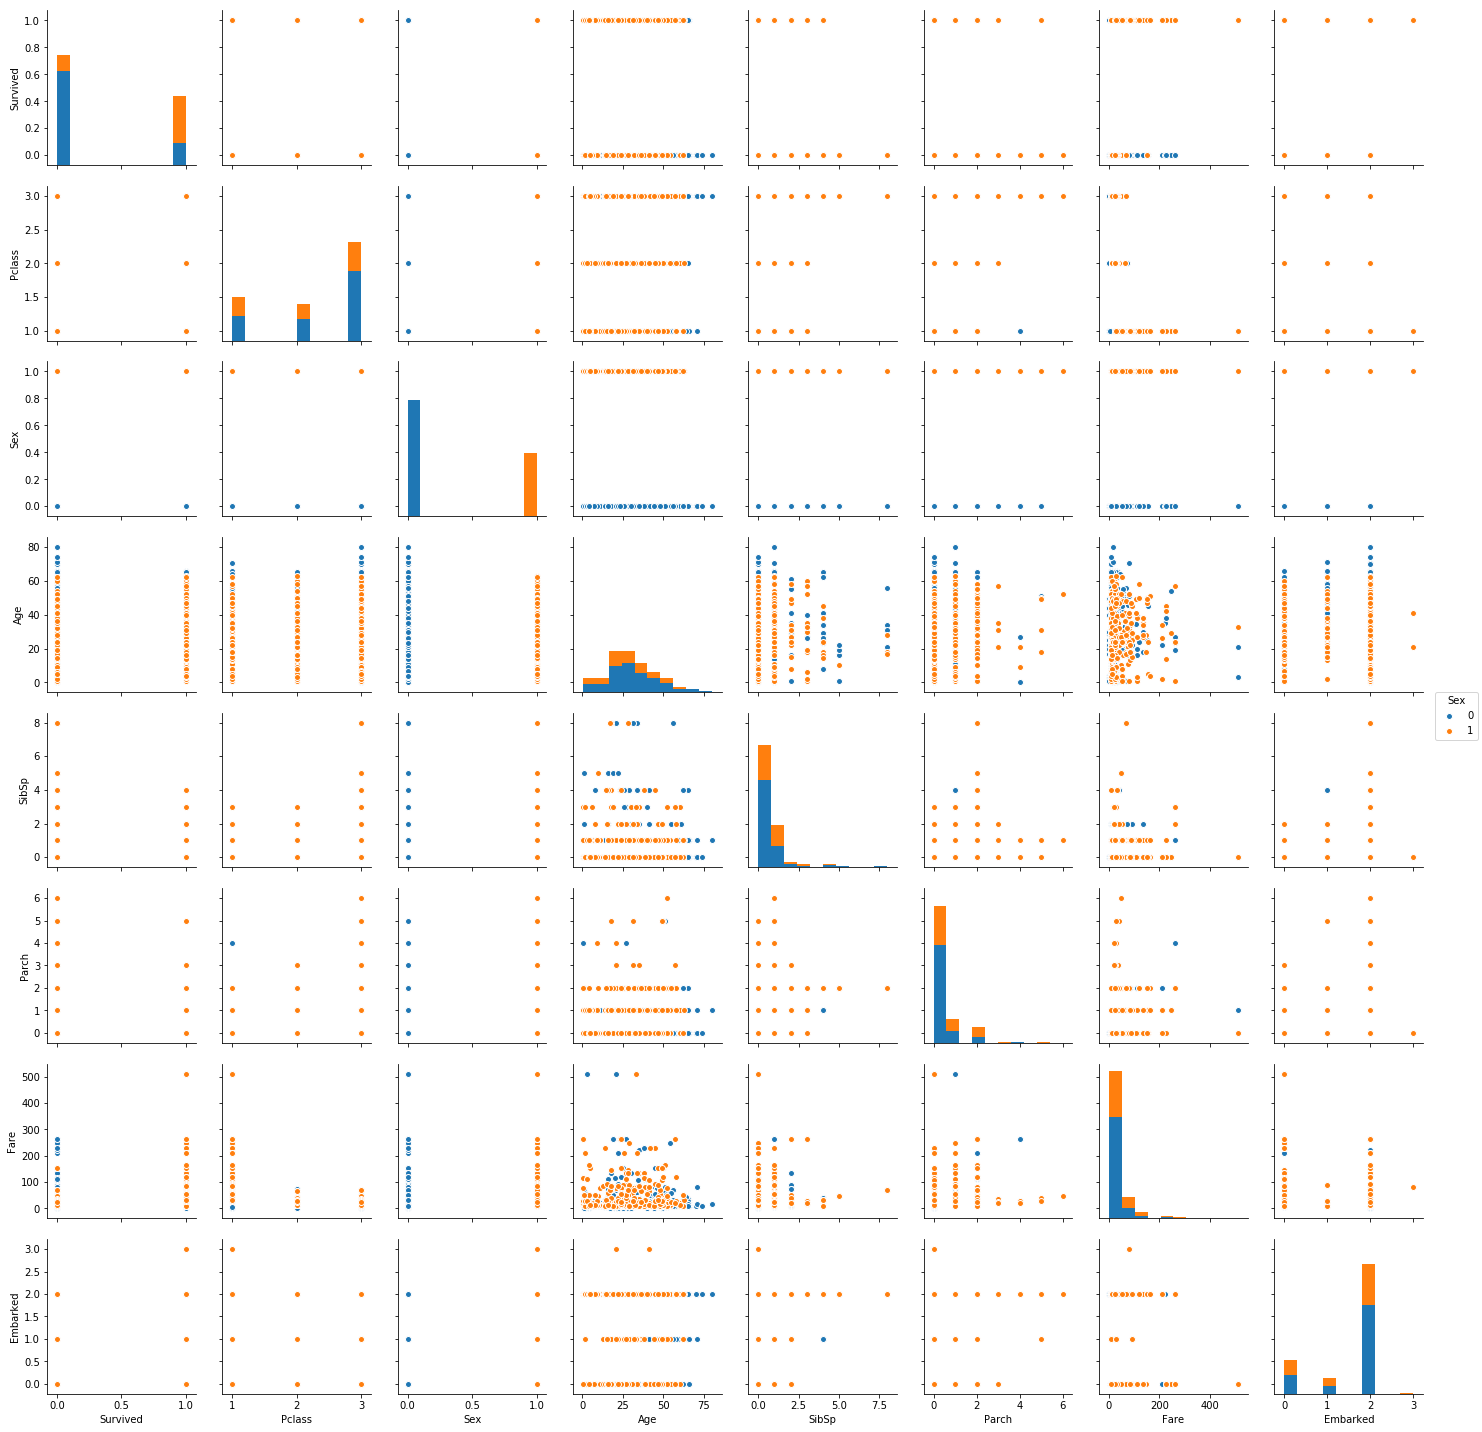

In [43]:
sns.

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


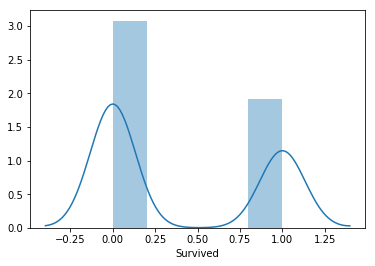

In [46]:
sns.distplot(titanic_valid.Survived)